In [70]:
!pip install jieba
!pip install networkx

In [71]:
import jieba
import os
import re
import numpy as np
import jieba.posseg as psg
import networkx as nx
import pandas as pd
import math

In [72]:
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

/Users/xijia/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


# SNA (semantic network analysis)

## Introduction

This notebook goes through an example of semantic network analysis. Specifically, we'll present:

1. **Reading the data - ** since we already have data from PeopleDaily website, we can directly read them from csv file.
2. **Cleaning the data - ** we will use basic/popular text pre-processing methods
3. **Stop words and tokenization - ** we will use jieba library to do tokenization
4. **semantic network analysis - ** we will use Co-occurrence Network to do SNA

### Readig the data

Since we already saved the data from People Daily, we can directly read them from csv file. And let's see the structure.

We use pandas library to read csv file by easily using pd.read_csv(fileName) function.

In [91]:
import re

with open("./FIFA_migrant workers_225_20_10_2022_18_01_2023.txt", "r") as f:
    lines = f.read()

def parse_text(text):
    article_list = text.split("____________________________________________________________\n")
    result = []
    for article in article_list:
        lines = article.split("\n")
        article_dict = {}
        for line in lines:
            line = line.strip()
            if(line==''):
                continue
            if line.startswith("Author:"):
                article_dict["Author"] = line.split(":", 1)[1].strip()
            elif line.startswith("Abstract:"):
                article_dict["Abstract"] = line.split(":", 1)[1].strip()
            elif line.startswith("Links:"):
                article_dict["Links"] = re.findall(r'(http[s]?://\S+)', line)
            elif line.startswith("https:") or line.startswith("http:"):
                if('Links' in article_dict):
                    article_dict["Links"].extend(re.findall(r'(http[s]?://\S+)', line))
                else:
                    article_dict["website"] = re.findall(r'(http[s]?://\S+)', line)
            elif line.startswith("Full text:"):
                article_dict["Full text"] = line.split(":", 1)[1].strip()
            elif line.startswith("Subject:"):
                article_dict["Subject"] = line.split(":", 1)[1].strip()
            elif line.startswith("Location:"):
                article_dict["Location"] = line.split(":", 1)[1].strip()
            elif line.startswith("People:"):
                article_dict["People"] = line.split(":", 1)[1].strip()
            elif line.startswith("Identifier / keyword:"):
                article_dict["Identifier / keyword"] = line.split(":", 1)[1].strip()
            elif line.startswith("Title:"):
                article_dict["Title"] = line.split(":", 1)[1].strip()
            elif line.startswith("Publication title:"):
                article_dict["Publication title"] = line.split(":", 1)[1].strip()
            elif line.startswith("Publication year:"):
                article_dict["Publication year"] = line.split(":", 1)[1].strip()
            elif line.startswith("Publication date:"):
                article_dict["Publication date"] = line.split(":", 1)[1].strip()
            elif line.startswith("Section:"):
                article_dict["Section"] = line.split(":", 1)[1].strip()
            elif line.startswith("Publisher:"):
                article_dict["Publisher"] = line.split(":", 1)[1].strip()
            elif line.startswith("Place of publication:"):
                article_dict["Place of publication"] = line.split(":", 1)[1].strip()
            elif line.startswith("Database:"):
                article_dict["Database"] = line.split(":", 1)[1].strip()
            elif line.startswith("Last updated:"):
                article_dict["Last updated"] = line.split(":", 1)[1].strip()
            elif line.startswith("Copyright:"):
                article_dict["Copyright"] = line.split(":", 1)[1].strip()
            elif line.startswith("Document URL:"):
                article_dict["Document URL"] = line.split(":", 1)[1].strip()
            elif line.startswith("ProQuest document ID:"):
                article_dict["ProQuest document ID"] = line.split(":", 1)[1].strip()
            elif line.startswith("Document type:"):
                article_dict["Document type"] = line.split(":", 1)[1].strip()
            elif line.startswith("Language of publication:"):
                article_dict["Language of publication"] = line.split(":", 1)[1].strip()
            elif line.startswith("Source type:"):
                article_dict["Source type"] = line.split(":", 1)[1].strip()
            elif line.startswith("Publication subject:"):
                article_dict["Publication subject"] = line.split(":", 1)[1].strip()
            elif line.startswith("Country of publication:"):
                article_dict["Country of publication"] = line.split(":", 1)[1].strip()
            else:
                article_dict["Title"] = line
        if( 'Title' not in article_dict or article_dict["Title"].strip() == ''):
            continue
        result.append(article_dict)
    return result

a = parse_text(lines)
a

In [66]:
import csv
import pandas as pd

# 设置表头
fields = ['Title', 'website', 'Author', 'Links', 'Website', 'Abstract', 'Full text', 'Subject', 'Location', 'People', 'Identifier / keyword', 'Publication title', 'Publication year', 'Publication date', 'Section', 'Publisher', 'Place of publication', 'Document type', 'Country of publication', 'Copyright', 'Database', 'ProQuest document ID', 'Publication subject', 'Language of publication', 'Last updated', 'Source type', 'Document URL']

# 写入csv
filename = "news_data.csv"
with open(filename, 'w', encoding='utf-8', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fields)

    writer.writeheader()
    for data in a:
        writer.writerow(data)


In [121]:
#read data from file
data_df = pd.read_csv('./news_data.csv')
data_df

,Title,website,Author,Links,Website,Abstract,Full text,Subject,Location,People,...,Document type,Country of publication,Copyright,Database,ProQuest document ID,Publication subject,Language of publication,Last updated,Source type,Document URL
0,New Year. New Hope. Here’s your A-Z for 2023,['http://ludwig.lub.lu.se/login?url=https://ww...,"Sheridan, Colin",['http://linksource.ebsco.com/linking.aspx?sid...,NaN,None available.,NaN,Tournaments & championships; Coaches & manager...,Ireland,"Lowry, Shane",...,News,"Ireland, Cork","Copyright Landmark Digital Limited Jan 2, 2023",Global Newsstream,2759911297,General Interest Periodicals--Ireland,English,2023-01-03,Newspaper,http://ludwig.lub.lu.se/login?url=https://www....
1,World: Beer And Boycotts: Why FIFA's Corporate...,['http://ludwig.lub.lu.se/login?url=https://ww...,NaN,['http://linksource.ebsco.com/linking.aspx?sid...,NaN,None available.,NaN,Migrant workers; Olympic games; LGBTQ rights m...,Qatar; China,NaN,...,News,"Thailand, Bangkok","Copyright Thai News Service Group Dec 27, 2022",Global Newsstream,2758095486,"General Interest Periodicals--Philippines, Gen...",English,2022-12-26,Newspaper,http://ludwig.lub.lu.se/login?url=https://www....
2,33rd team of World Cup 2022: Ignored and forgo...,['http://ludwig.lub.lu.se/login?url=https://ww...,"Joshi, Pushpa R",['http://linksource.ebsco.com/linking.aspx?sid...,NaN,None available.,NaN,Tournaments & championships; Migrant workers; ...,Nepal; Qatar,NaN,...,News,"India, Kathmandu","Copyright 2023 APCA Nepal Pvt. Ltd., distribut...",Global Newsstream,2761476280,General Interest Periodicals--Nepal,English,2023-01-07,Newspaper,http://ludwig.lub.lu.se/login?ur l=https://www...
3,Was a £180bn World Cup really worth it for Qatar?,['http://ludwig.lub.lu.se/login?url=https://ww...,"Arlidge, John",['http://linksource.ebsco.com/linking.aspx?sid...,NaN,None available.,NaN,Football; Alliances; Airports; Tournaments & c...,Qatar; United Kingdom--UK; Ukraine,NaN,...,News,"United Kingdom, London",Copyright Telegraph Media Group Limited Dec 24...,Global Newsstream,2757874229,General Interest Periodicals--Great Britain,English,2022-12-25,Newspaper,http://ludwig.lub.lu.se/login?url=https://www....
4,ISSN: 03071235,['http://ludwig.lub.lu.se/login?url=https://ww...,NaN,['http://linksource.ebsco.com/linking.aspx?sid...,NaN,None available.,NaN,Sports fans; Alliances; Airports; Tournaments ...,Qatar; United Kingdom--UK; Ukraine,NaN,...,News,"United Kingdom, London (UK)","Copyright Daily Telegraph Dec 24, 2022",Global Newsstream,2757240794,General Interest Periodicals--Great Britain,English,2022-12-24,Newspaper,http://ludwig.lub.lu.se/login?url=https://www....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,World Cup,['http://ludwig.lub.lu.se/login?url=https://ww...,NaN,['http://linksource.ebsco.com/linking.aspx?sid...,NaN,None available.,HOST: OMAR SACHEDINA,Tournaments & championships; Migrant workers; ...,Canada; Qatar,NaN,...,News,"Canada, Scarborough","Copyright CTV Television, Inc. Oct 27, 2022",Global Newsstream,2729306050,General Interest Periodicals--Canada,English,2022-10-28,Newspaper,http://ludwig.lub.lu.se/login?url=https://www....
222,Full text availability: This publication may b...,['http://ludwig.lub.lu.se/login?url=https://ww...,"Noble, Josh",['http://linksource.ebsco.com/linking.aspx?sid...,NaN,None available.,Harry Kane and other team captains will sport ...,Tournaments & championships; Soccer,England; Russia; Qatar; United Kingdom--UK,"Kane, Harry",...,News,"United Kingdom, London (UK)","Copyright The Financial Times Limited Oct 22, ...",Global Newsstream,2737958297,"Business And Economics--Banking And Fin ance, ...",English,2022-11-21,Newspaper,http://ludwig.lub.lu.se/login?url=https://www....
223,World: Qatar: Labour reform unfinished and com...,['http://ludwig.lub.lu.se/login?url=https://ww...,NaN,['http://linksource.ebsco.com/linking.aspx?sid...,NaN,None available.,The Qatari authorities mus

### Cleaning data
As we can see above in the table, the title "full content" is what we want to process. We can see there are several problems:
1. The columns is "ful content". It is hard to access a column with spaces inside title. Normally, we access a column by easily using `dataFrame.conlumnTitle`.
2. The contents all include `\n\nHome>>\n\t\t\n` and we do not need it.
3. We would like the texts are lowercase, without square brackets, punctuation and words containing numbers. We will use re and string library to help this.

In [120]:
#replace spance with _ for all the column titles
# data_df.columns = data_df.columns.str.replace(' ','_')
# replace useless word with empty string
# data_df[0]
# data_ct = data_df[len(data_df)][1:].str.replace('\n\nHome>>\n\t\t\n','')
data_ct = data_df['full contents'][1:].str.replace('\n\nHome>>\n\t\t\n','')
# data_ct = lines
data_ct

1      China aims high in agricultural sci-tech innov...
2      Commentary: China's independent innovation to ...
3      CES 2022 concludes in Las Vegas featuring inno...
4      Innovation brings Chinese cultural relics back...
5      Into 3rd year, COVID-19 pandemic leads to chao...
                             ...                        
495    Into 3rd year, COVID-19 pandemic leads to chao...
496    Huawei contributes to global ecological and en...
497    China fully leverages sci-tech innovations to ...
498    Innovative measures ensure smooth postgrad exa...
499    Innovation, green growth drive Beijing-Tianjin...
Name: full contents, Length: 499, dtype: object

In [93]:
#use re and string library
#https://docs.python.org/3/library/re.html
import re
import string

#Regular expression
def clean_text_round1(text):
    text = text.lower() #Make text lowercase
    text = re.sub('\[.*?\]', '', text) #remove text in square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #remove punctuation
    text = re.sub('\w*\d\w*', '', text) #remove words containing numbers
    return text

round1 = lambda x: clean_text_round1(x)

In [94]:
#apply the function
data_clean = pd.DataFrame(data_ct.apply(round1))
data_clean

AttributeError: 'str' object has no attribute 'apply'

In [8]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [9]:
data_clean = pd.DataFrame(data_clean.full_contents.apply(round2))

### Stop words and tokenization

Stop words are the words you do not want to count in the list.

In [10]:
'''
This function combine all the clean_data to one single string,
which is in order to use psg.cut to divide them into words(tokenization)
and we can count the top words
'''
def combine_data(clean_data):
    data_list=clean_data.tolist()
    combine_text = ' '.join(data_list)
    return combine_text

In [11]:
'''
This function is to rank all the highest word frequencies that appear in the text
'''
def get_wordlist(text,maxn,stop_words):
    counts={}
    
    text_seg = psg.cut(text)
    for word_flag in text_seg:
        word = word_flag.word
        if len(word)>1 and word not in stop_words:
            counts[word]=counts.get(word,0)+1
            
    
    words= sorted(counts.items(),key=lambda x:x[1],reverse=True)
    words= list(dict(words).keys())[0:maxn]
    
    return words

In [12]:
#settings
stop_word_list=['The', 'Xinhua', 'green', '2022', '2021', 'the']
n_topwords=40

In [13]:
#we use text.ENGLISH_STOP_WORDS as the basic english stop words that always used and add our stop list
stop_words = text.ENGLISH_STOP_WORDS.union(stop_word_list)
combined_data = combine_data(data_clean.full_contents)
topwords = get_wordlist(combined_data,n_topwords,stop_words)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/ml/hyfz6s1s0w3fkdnl966n2fdc0000gn/T/jieba.cache
Loading model cost 0.920 seconds.
Prefix dict has been built successfully.


In [14]:
# We can print it, the top 40 words
topwords

['beijing',
 'china',
 'said',
 'development',
 'innovation',
 'chinese',
 'national',
 'venues',
 'new',
 'winter',
 'chinas',
 'technology',
 'sports',
 'cultural',
 'construction',
 'international',
 'including',
 'people',
 'games',
 'scitech',
 'year',
 'according',
 'xinhua',
 'olympic',
 'exam',
 'snow',
 'achievements',
 'data',
 'ces',
 'park',
 'public',
 'global',
 'event',
 'huawei',
 'university',
 'agricultural',
 'percent',
 'relics',
 'project',
 'xian']

### Co-occurrence Network

In [15]:
#Count the frequency of each occurrence of a certain word in the different articles
'''
Input: topwords -- topwords list, 
       text -- should contain all the articles(each one with '\n')
       stop_words -- the list of stop words
       
output:
    text_lines_seg: the arrary containing elements that the words in the topwords and also in the article
    word_docs: the frequency of the words in topwords(ordered by descending)
'''
def get_t_seg(topwords,text,stop_words,save_name):
    word_docs = {}    
    text_lines_seg =[]
    text_lines = text.split("\n")
    with open(save_name, 'a+', encoding = 'utf-8-sig') as written_file:
        for line in text_lines:
            t_seg = []
            text_seg = psg.cut(line)
            for word_flag in text_seg:
                word = word_flag.word
                written_file.write(word)
                if len(word)>1 and word not in stop_words:
                    if word in topwords:
                        t_seg.append(word) 
            written_file.write('\n')
            t_seg=list(set(t_seg))
            for word in t_seg:
                word_docs[word]=word_docs.get(word,0)+1
            text_lines_seg.append(t_seg)
    return text_lines_seg,word_docs

In [16]:
save_text_name = 'seg_en.txt'
format_s = '\n'.join(data_clean.full_contents.tolist())
t_segs,word_docs = get_t_seg(topwords,format_s,stop_words, save_text_name)

In [17]:
#print words_docs
word_docs

{'scitech': 150,
 'innovation': 299,
 'agricultural': 50,
 'development': 299,
 'according': 399,
 'chinese': 349,
 'new': 300,
 'construction': 199,
 'data': 200,
 'china': 349,
 'beijing': 299,
 'national': 349,
 'technology': 349,
 'including': 400,
 'said': 449,
 'xinhua': 349,
 'achievements': 150,
 'international': 300,
 'global': 150,
 'year': 350,
 'percent': 200,
 'chinas': 349,
 'event': 100,
 'ces': 50,
 'venues': 149,
 'people': 150,
 'public': 299,
 'university': 199,
 'games': 149,
 'relics': 50,
 'cultural': 100,
 'park': 149,
 'huawei': 50,
 'project': 100,
 'winter': 99,
 'snow': 99,
 'sports': 99,
 'olympic': 99,
 'exam': 50,
 'xian': 50}

In [22]:
#This function calculate the co-occurrence matrix
def get_comatrix(text_lines_seg):
    comatrix = pd.DataFrame(np.zeros([len(topwords),len(topwords)]),columns=topwords,index=topwords)
    for t_seg in text_lines_seg:
        for i in range(len(t_seg)-1):
                for j in range(i+1,len(t_seg)):
                    comatrix.loc[t_seg[i],t_seg[j]]+=1
                    comatrix.loc[t_seg[j],t_seg[i]]+=1
    for k in range(len(comatrix)):
        comatrix.iloc[k,k]=0
    return comatrix

In [23]:
n = len(t_segs)
co_matrix = get_comatrix(t_segs)
co_matrix

,beijing,china,said,development,innovation,chinese,national,venues,new,winter,...,public,global,event,huawei,university,agricultural,percent,relics,project,xian
beijing,0.0,299.0,249.0,249.0,249.0,199.0,299.0,99.0,150.0,99.0,...,149.0,50.0,50.0,0.0,99.0,50.0,150.0,50.0,50.0,0.0
china,299.0,0.0,299.0,299.0,249.0,249.0,349.0,99.0,150.0,99.0,...,199.0,100.0,50.0,50.0,99.0,50.0,150.0,50.0,100.0,0.0
said,249.0,299.0,0.0,249.0,299.0,349.0,299.0,99.0,250.0,49.0,...,299.0,150.0,50.0,50.0,199.0,50.0,150.0,50.0,50.0,50.0
development,249.0,299.0,249.0,0.0,199.0,199.0,299.0,99.0,100.0,99.0,...,149.0,100.0,50.0,50.0,49.0,50.0,150.0,0.0,100.0,0.0
innovation,249.0,249.0,299.0,199.0,0.0,249.0,249.0,99.0,150.0,49.0,...,149.0,100.0,50.0,0.0,99.0,50.0,100.0,50.0,0.0,0.0
chinese,199.0,249.0,349.0,199.0,249.0,0.0,249.0,99.0,200.0,49.0,...,199.0,150.0,50.0,50.0,149.0,50.0,50.0,50.0,50.0,50.0
national,299.0,349.0,299.0,299.0,249.0,249.0,0.0,99.0,150.0,99.0,...,199.0,100.0,50.0,50.0,99.0,50.0,150.0,50.0,100.0,0.0
venues,99.0,99.0,99.0,99.0,99.0,99.0,99.0,0.0,100.0,99.0,...,49.0,50.0,100.0,0.0,49.0,0.0,50.0,0.0,50.0,0.0
new,150.0,150.0,250.0,100.0,150.0,200.0,150.0,100.0,0.0,50.0,...,150.0,50.0,100.0,0.0,150.0,50.0,100.0,50.0,50.0,50.0
winter,99.0,99.0,49.0,99.0,49.0,49.0,99.0,99.0,50.0,0.0,...,49.0,0.0,50.0,0.0,49.0,0.0,50.0,0.0,50.0,0.0


In [20]:
#get co-occurrence networks
def get_net(co_matrix,topwords):
    g = nx.Graph()
    for i in range(len(topwords)-1):
        word = topwords[i]
        for j in range(i+1,len(topwords)):
            w=0
            word2 = topwords[j]
            w = co_matrix.loc[word][word2]+co_matrix.loc[word2][word]
            if w>0:
                g.add_edge(word,word2,weight=w)
    return g


Bad key savefig.frameon in file /Users/xijia/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/xijia/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/xijia/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an 

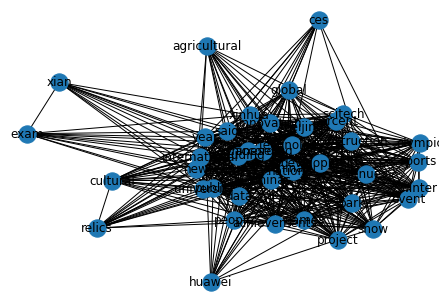

In [21]:
co_net =get_net(co_matrix,topwords)
nx.draw(co_net, with_labels = True)

In [37]:
#export to gephi
nx.write_gexf(co_net,"./co_net.gexf")